#Загрузка моделей и библиотек

In [ ]:
!pip install catboost
!pip install pymorphy2

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy2
import os
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
from sklearn.cluster import DBSCAN
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, accuracy_score
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [29]:
# Загрузка данных
train_groups = pd.read_csv('train_groups.csv')
test_groups = pd.read_csv('test_groups.csv')
docs_titles = pd.read_csv('docs_titles.tsv', sep='\t')

In [30]:
# Объединение заголовков с данными групп
train_data = train_groups.merge(docs_titles, on='doc_id')
test_data = test_groups.merge(docs_titles, on='doc_id', how='left')

In [31]:
# Просмотр пропусков
train_data.isna().sum(), test_data.isna().sum()

(pair_id      0
 group_id     0
 doc_id       0
 target       0
 title       16
 dtype: int64,
 pair_id      0
 group_id     0
 doc_id       0
 title       92
 dtype: int64)

In [32]:
# Обработка отсутствующих значений
train_data['title'].fillna('', inplace=True)
test_data['title'].fillna('', inplace=True)

# Предобработка данных

In [ ]:
# Загрузка данных для NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Стоп-слова и шум
stop_words = set(stopwords.words('russian')) | set(stopwords.words('english'))

morph = pymorphy2.MorphAnalyzer()

In [34]:
def preprocess_text(text):
    """
    Токенизация + лемматизация текста
    """
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text.lower())  # Удаление спецсимволов
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and not token.isdigit()]
    tokens = [morph.parse(word)[0].normal_form for word in tokens]
    return tokens

train_data['title_processed'] = train_data['title'].apply(preprocess_text)
test_data['title_processed'] = test_data['title'].apply(preprocess_text)

# Векторизация BERT

In [9]:
# Векторизация с помощью BERT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu()

train_data['title_embeddings'] = train_data['title'].apply(lambda x: get_bert_embeddings(x).numpy())
test_data['title_embeddings'] = test_data['title'].apply(lambda x: get_bert_embeddings(x).numpy())

# Создание фичей

## BERT фичи

In [10]:
def embeddings_to_features(data, column_prefix):
    """
    Преобразуем эмбеддинги в фичи
    """
    embeddings = np.stack(data[column_prefix + '_embeddings'].values)
    feature_names = [f"{column_prefix}_embedding_{i}" for i in range(embeddings.shape[1])]
    features_df = pd.DataFrame(embeddings, columns=feature_names, index=data.index)
    return features_df

train_features = embeddings_to_features(train_data, 'title')
test_features = embeddings_to_features(test_data, 'title')

In [35]:
def add_new_features(data):
    """
    Добавляем новые признаки: длина заголовка и число уникальных слов
    """
    data['title_length'] = data['title'].apply(lambda x: len(x.split()))
    data['unique_words'] = data['title_processed'].apply(lambda x: len(set(x)))
    return data

train_data = add_new_features(train_data)
test_data = add_new_features(test_data)

## Косинусные сходства Tfidf

In [36]:
def vectorize_group(group):
    """
    Векторизуем группу документов с кастомным токенайзером
    """
    vectorizer = TfidfVectorizer(tokenizer=preprocess_text)
    vectors = vectorizer.fit_transform(group['title'])
    return vectors

In [37]:
def data_to_tfidf(data_grouped):
    """
    Создание tfidf матрицы для данных по группам
    """
    tfidf_data = pd.DataFrame()
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        # Для каждой группы получаем векторное представление
        tfidf_matrix = vectorize_group(group)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])], index=group.index)
        # Соединяем в df все группы
        tfidf_data = pd.concat([tfidf_data, tfidf_df])
    return tfidf_data

In [38]:
def cosine_matrix_group(group):
    """
    Вычисление матрицы косинусных расстояний для группы
    """
    tfidf_matrix = vectorize_group(group)
    cosine_matrix = cosine_similarity(tfidf_matrix)
    return cosine_matrix

In [39]:
def calc_cosine_similarity(data_grouped, count=10):
    """
    Возвращаем топ косинусных сходств для каждого документа группы
    """
    similarity_features_list = []
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        cosine_matrix = cosine_matrix_group(group)
        for k, (idx, row) in enumerate(group.iterrows()):
            similarities = []
            for j in range(len(group)):
                if k == j:
                    continue
                similarities.append(cosine_matrix[k, j])
            top_similarities = sorted(similarities, reverse=True)[:count]
            similarity_record = [row['pair_id']] + top_similarities
            similarity_features_list.append(similarity_record)
    similarity_columns = ['pair_id'] + [f'top_{i+1}_similarity' for i in range(count)]
    similarity_features = pd.DataFrame(similarity_features_list, columns=similarity_columns)
    return similarity_features

# Кластеризация

In [40]:
def clustering_features(data_grouped, eps=0.5, min_samples=5, metric='cosine'):
    """
    Возвращаем кластер для каждого документа группы
    """
    clustering_features_list = []
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        cosine_matrix = cosine_matrix_group(group)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(cosine_matrix)
        cluster_labels = dbscan.labels_
        for k, (idx, row) in enumerate(group.iterrows()):
            clustering_record = [row['pair_id'], cluster_labels[k]]
            clustering_features_list.append(clustering_record)
    clustering_columns = ['pair_id', 'cluster']
    clustering_features = pd.DataFrame(clustering_features_list, columns=clustering_columns)
    return clustering_features

## Общие слова пар документов

In [41]:
def count_common_words(list1, list2):
    counter1 = Counter(list1)
    counter2 = Counter(list2)
    common_words = counter1 & counter2  # Находит общие элементы с минимальным счетчиком
    return sum(common_words.values())

In [42]:
def calc_count_common_words(data_grouped, count=10):
    """
    Возвращаем топ общих слов для каждого документа группы
    """
    common_words_features_list = []
    for name, group in tqdm(data_grouped, desc="Processing groups"):
        for k, (idx, row) in enumerate(group.iterrows()):
            common_words = []
            for j, (idx2, row2) in enumerate(group.iterrows()):
                if k == j:
                    continue
                common_words.append(count_common_words(row['title_processed'], row2['title_processed']))
            top_common_words = sorted(common_words, reverse=True)[:count]
            common_words_record = [row['pair_id']] + top_common_words
            common_words_features_list.append(common_words_record)
    common_words_columns = ['pair_id'] + [f'top_{i+1}_common_words' for i in range(count)]
    common_words_features = pd.DataFrame(common_words_features_list, columns=common_words_columns)
    return common_words_features

# Объединение данных и фичей в датасет

In [44]:
# Разбиваем train и test по группам на основе id
train_data_grouped = train_data.groupby('group_id')
test_data_grouped = test_data.groupby('group_id')

In [20]:
# Фичи для трейна и теста
train_similarity_features = calc_cosine_similarity(train_data_grouped)
train_clustering_features = clustering_features(train_data_grouped)
train_common_words_features = calc_count_common_words(train_data_grouped)

test_similarity_features = calc_cosine_similarity(test_data_grouped)
test_clustering_features = clustering_features(test_data_grouped)
test_common_words_features = calc_count_common_words(test_data_grouped)

# Заполняем пропуски нулями
train_similarity_features = train_similarity_features.fillna(0)
train_common_words_features = train_common_words_features.fillna(0)

test_similarity_features = test_similarity_features.fillna(0)
test_common_words_features = test_common_words_features.fillna(0)

Processing groups: 100%|██████████| 180/180 [01:48<00:00,  1.65it/s]


In [47]:
# Объединяем новые признаки с исходным датасетом
train_data = train_data.merge(train_similarity_features, on=['pair_id'])
train_data = train_data.merge(train_clustering_features, on=['pair_id'])
train_data = train_data.merge(train_common_words_features, on=['pair_id'])

test_data = test_data.merge(test_similarity_features, on=['pair_id'])
test_data = test_data.merge(test_clustering_features, on=['pair_id'])
test_data = test_data.merge(test_common_words_features, on=['pair_id'])

In [49]:
# Объединяем с BERT признаками
train_data = pd.concat([train_data, train_features], axis=1)
test_data = pd.concat([test_data, test_features], axis=1)

# Разбиение на train, val и test

In [51]:
X_train = train_data.drop(columns=['doc_id', 'pair_id', 'group_id', 'target', 'title', 'title_processed', 'title_embeddings'], axis=1)
y_train = train_data['target']

X_test = test_data.drop(columns=['doc_id', 'pair_id', 'group_id', 'title', 'title_processed', 'title_embeddings'], axis=1)

In [52]:
# Разбиение данных на обучающую и тестовую выборки
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_indices, val_indices = next(splitter.split(X_train, y_train, train_groups['group_id']))

X_train_split = X_train.iloc[train_indices]
y_train_split = y_train.iloc[train_indices]

X_val_split = X_train.iloc[val_indices]
y_val_split = y_train.iloc[val_indices]

# Обучение и инференс модели

In [ ]:
# Обучение модели CatBoost
model = CatBoostClassifier()
train_pool = Pool(X_train_split, y_train_split)
val_pool = Pool(X_val_split, y_val_split)
model.fit(train_pool, eval_set=val_pool)

In [54]:
# Предсказания на валидационной выборке
val_predictions = model.predict(val_pool)

In [55]:
# Оценка модели на валидации
accuracy = accuracy_score(y_val_split, val_predictions)
f1 = f1_score(y_val_split, val_predictions)
report = classification_report(y_val_split, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(report)

Accuracy: 0.8501742160278746
F1-score: 0.6587301587301586
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2704
           1       0.65      0.67      0.66       740

    accuracy                           0.85      3444
   macro avg       0.78      0.79      0.78      3444
weighted avg       0.85      0.85      0.85      3444



# Важность признаков

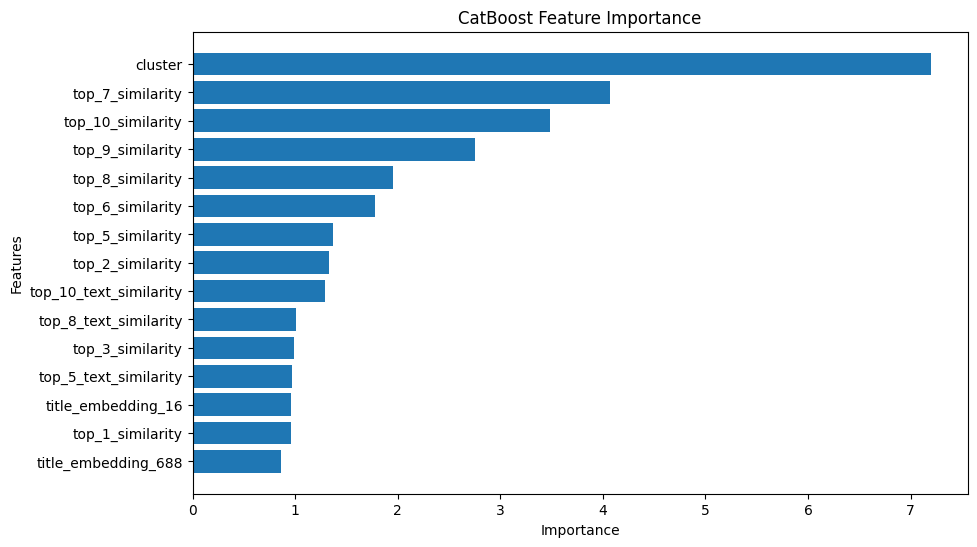

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()[-15:]
feature_importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Предсказание на тестовом наборе
test_pool = Pool(X_test)
test_predictions = model.predict(test_pool)

In [ ]:
# Сохранение результатов
submission = test_groups[['pair_id']].copy()
submission['target'] = test_predictions
submission.to_csv('submission.csv', index=False)

print('Файл с предсказаниями создан: submission.csv')

Файл с предсказаниями создан: submission.csv


# Инференс

In [56]:
test_pool = Pool(X_test)

# Предсказание на тестовом наборе
test_predictions = model.predict(test_pool)

# Сохранение результатов
submission = test_groups[['pair_id']].copy()
submission['target'] = test_predictions
submission.to_csv('/content/submission.csv', index=False)

print('Файл с предсказаниями создан: submission.csv')

Файл с предсказаниями создан: submission.csv
